In [3]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn import decomposition
from scipy import linalg
import matplotlib.pyplot as plt

In [2]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


In [5]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
remove = ('headers', 'footers', 'quotes')
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=remove)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories, remove=remove)

In [6]:
vectorizer = CountVectorizer(stop_words='english')
vectors = vectorizer.fit_transform(newsgroups_train.data).todense() # (documents, vocab)
vectors.shape

(2034, 26576)

In [9]:
m,n = vectors.shape
d = 8

In [10]:
nmf = decomposition.NMF(n_components=d, random_state=1)
W1 = nmf.fit_transform(vectors)
H1=nmf.components_

In [12]:
H1[:8]

array([[1.25484760e-01, 0.00000000e+00, 1.20162870e-05, ...,
        2.75869253e-05, 5.51738507e-05, 2.71634332e-04],
       [1.17306638e-01, 1.12783785e-01, 8.70405270e-05, ...,
        1.37106144e-04, 2.74212287e-04, 5.45959193e-02],
       [3.13322686e-03, 3.76665172e-01, 1.91501058e-04, ...,
        1.96297762e-04, 3.92595524e-04, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.87339660e-02, 3.73298168e-01, 1.06186626e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.53834682e-02, 3.53008283e-02, 0.00000000e+00, ...,
        7.28024443e-04, 1.45604889e-03, 0.00000000e+00]])

In [15]:
vocab = np.array(vectorizer.get_feature_names())


In [16]:
num_top_words=8

def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

In [17]:
show_topics(H1)

['jpeg image gif file color images format quality',
 'edu graphics pub mail 128 ray send ftp',
 'launch space satellite commercial market satellites year data',
 'jesus matthew prophecy people said messiah david isaiah',
 'image data available software processing ftp edu analysis',
 'god atheists atheism religious believe people religion does',
 'space nasa shuttle available information center data list',
 'probe lunar mars moon surface probes orbit earth']

 (TF-IDF) is a way to normalize term counts by taking into account how often they appear in a document, how long the document is, and how commmon/rare the term is.

TF = (# occurrences of term t in document) / (# of words in documents)

IDF = log(# of documents / # documents with term t in it)

In [18]:
vectorizer_tfidf = TfidfVectorizer(stop_words='english')
vectors_tfidf = vectorizer_tfidf.fit_transform(newsgroups_train.data)

In [19]:
W2 = nmf.fit_transform(vectors_tfidf)
H2 = nmf.components_

In [20]:
show_topics(H1)


['jpeg image gif file color images format quality',
 'edu graphics pub mail 128 ray send ftp',
 'launch space satellite commercial market satellites year data',
 'jesus matthew prophecy people said messiah david isaiah',
 'image data available software processing ftp edu analysis',
 'god atheists atheism religious believe people religion does',
 'space nasa shuttle available information center data list',
 'probe lunar mars moon surface probes orbit earth']

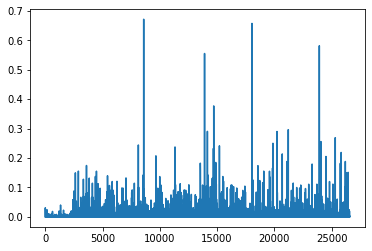

In [22]:
plt.plot(H2[0])

Applying SGD to NMF
Goal: Decompose V(m×n) into
V≈WH
where W(m×d) and H(d×n), W,H>=0, and we've minimized the Frobenius norm of V−WH.

Approach: We will pick random positive W & H, and then use SGD to optimize.

In [23]:
lam=1e3
lr=1e-2
m, n = vectors_tfidf.shape

In [24]:
W1 = nmf.fit_transform(vectors)
H1 = nmf.components_

In [28]:
show_topics(H1)

['jpeg image gif file color images format quality',
 'edu graphics pub mail 128 ray send ftp',
 'launch space satellite commercial market satellites year data',
 'jesus matthew prophecy people said messiah david isaiah',
 'image data available software processing ftp edu analysis',
 'god atheists atheism religious believe people religion does',
 'space nasa shuttle available information center data list',
 'probe lunar mars moon surface probes orbit earth']

In [29]:
mu = 1e-6
def grads(M, W, H):
    R = W@H-M
    return R@H.T + penalty(W, mu)*lam, W.T@R + penalty(H, mu)*lam # dW, dH

In [30]:
def penalty(M, mu):
    return np.where(M>=mu,0, np.min(M - mu, 0))


In [31]:
def upd(M, W, H, lr):
    dW,dH = grads(M,W,H)
    W -= lr*dW; H -= lr*dH

In [32]:
def report(M,W,H): 
    print(np.linalg.norm(M-W@H), W.min(), H.min(), (W<0).sum(), (H<0).sum())

In [33]:
W = np.abs(np.random.normal(scale=0.01, size=(m,d)))
H = np.abs(np.random.normal(scale=0.01, size=(d,n)))

In [35]:
W.shape

(2034, 8)

In [36]:
report(vectors_tfidf, W, H)


44.482004119469714 2.171755457451897e-07 6.166888836788525e-08 0 0


In [37]:
upd(vectors_tfidf,W,H,lr)


In [38]:
report(vectors_tfidf, W, H)


44.45474142672405 -0.0013385032690388671 -0.00012303554345194048 693 851


In [39]:
for i in range(50): 
    upd(vectors_tfidf,W,H,lr)
    if i % 10 == 0: report(vectors_tfidf,W,H)

44.44678197849361 -0.0010491946860648432 -7.999313430951616e-05 579 759
44.37887507639903 -0.0005215495491994622 -6.213509316471791e-05 182 1087
44.351747757137154 -0.000266520747814589 -4.6146241450333145e-05 76 1911
44.32846208481559 -0.00020338255005040022 -5.165107170763299e-05 78 2568
44.30317767402646 -0.00010491631770538924 -7.917289478374755e-05 86 3404
